Below is the skeleton code to make the tic tac toe game.

In [16]:
import random
import math
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
import os

making the rules for the winner and draw

https://github.com/anuragjain-git/unbeatable-tictactoe-bot/blob/main/tictactoe.py

In [17]:
# Utility functions
def check_winner(board, player):
    """Check if the player has won the game."""
    winning_combinations = [
        [0, 1, 2], [3, 4, 5], [6, 7, 8],  # Rows
        [0, 3, 6], [1, 4, 7], [2, 5, 8],  # Columns
        [0, 4, 8], [2, 4, 6]              # Diagonals
    ]
    return any(all(board[pos] == player for pos in combo) for combo in winning_combinations)

def is_draw(board):
    """Check if the game is a draw."""
    return ' ' not in board and not (check_winner(board, 'X') or check_winner(board, 'O'))

def available_moves(board):
    """Return a list of available moves."""
    return [i for i, spot in enumerate(board) if spot == ' ']

def print_board(board):
    """Print the current board state."""
    print(f"{board[0]} | {board[1]} | {board[2]}")
    print("--+---+--")
    print(f"{board[3]} | {board[4]} | {board[5]}")
    print("--+---+--")
    print(f"{board[6]} | {board[7]} | {board[8]}")

In [18]:
# State statistics for tracking game outcomes
state_statistics = {}

def update_state_statistics(state, winner):
    """Update the statistics for a given game state."""
    if state not in state_statistics:
        state_statistics[state] = [0, 0, 0, 0]  # [games_played, x_wins, o_wins, draws]
    state_statistics[state][0] += 1  # Increment games played
    if winner == 'X':
        state_statistics[state][1] += 1  # Increment X wins
    elif winner == 'O':
        state_statistics[state][2] += 1  # Increment O wins
    elif winner == 'draw':
        state_statistics[state][3] += 1  # Increment draws

def simulate_game(agent, verbose=False):
    """Simulate a single game and update state statistics."""
    board = [' '] * 9
    current_player = 'X'
    state_action_history = []

    while True:
        state = tuple(board)
        action = agent.choose_action(board, current_player)
        board[action] = current_player
        state_action_history.append((state, action, current_player))

        if check_winner(board, current_player):
            winner = current_player
            for s, a, p in state_action_history:
                update_state_statistics(s, winner=winner)
            break
        elif is_draw(board):
            for s, a, p in state_action_history:
                update_state_statistics(s, winner='draw')
            break
        else:
            current_player = 'O' if current_player == 'X' else 'X'

    if verbose:
        print_board(board)

def train_agent(agent, episodes):
    """Train the agent by simulating games and updating state statistics."""
    for episode in range(episodes):
        simulate_game(agent)
    print(f"Training complete after {episodes} episodes.")

def calculate_win_draw_rates():
    """Calculate the win and draw rates for all encountered game states."""
    win_draw_rates = {}
    for state, stats in state_statistics.items():
        games_played, x_wins, o_wins, draws = stats
        if games_played > 0:
            x_win_rate = x_wins / games_played
            o_win_rate = o_wins / games_played
            draw_rate = draws / games_played
            win_draw_rates[state] = {
                'X_win_rate': x_win_rate,
                'O_win_rate': o_win_rate,
                'draw_rate': draw_rate
            }
    return win_draw_rates

Making our dataset of randomly played games

In [19]:
# Random Agent
class RandomAgent:
    def choose_action(self, board, player):
        """Randomly choose an available action."""
        return random.choice(available_moves(board))

# Generate training data from random games
def generate_training_data(num_games):
    def simulate_random_game():
        board = [" "] * 9
        current_player = 'X'
        game_data = []

        while True:
            move = random.choice(available_moves(board))
            board[move] = current_player
            game_data.append((board[:], current_player))

            if check_winner(board, current_player):
                return game_data, current_player
            if is_draw(board):
                return game_data, 'draw'

            current_player = 'O' if current_player == 'X' else 'X'

    data, labels = [], []
    for _ in range(num_games):
        game_data, result = simulate_random_game()
        for state, player in game_data:
            features = [1 if cell == 'X' else -1 if cell == 'O' else 0 for cell in state]
            label = 1 if result == player else -1 if result != 'draw' else 0
            data.append(features)
            labels.append(label)

    return np.array(data), np.array(labels)

# Train Random Forest bot
def train_random_forest_bot(num_games):
    data, labels = generate_training_data(num_games)
    X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    rf_model.fit(X_train, y_train)
    y_pred = rf_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Random Forest model accuracy: {accuracy:.2f}")
    return rf_model

# Random Forest Bot
class RandomForestBot:
    def __init__(self, model):
        self.model = model

    def choose_action(self, board, current_player):
        features = []
        moves = available_moves(board)
        for move in moves:
            temp_board = board[:]
            temp_board[move] = current_player
            features.append([1 if cell == 'X' else -1 if cell == 'O' else 0 for cell in temp_board])
        predictions = self.model.predict(features)
        best_move = moves[np.argmax(predictions)]
        return best_move

# Perfect Bot Logic (Minimax)
def evaluate(board):
    if check_winner(board, 'O'):
        return 1
    elif check_winner(board, 'X'):
        return -1
    else:
        return 0

def minimax(board, depth, alpha, beta, is_maximizing):
    score = evaluate(board)
    if score == 1 or score == -1 or is_draw(board):
        return score

    if is_maximizing:
        best_score = -math.inf
        for i in available_moves(board):
            board[i] = 'O'
            best_score = max(best_score, minimax(board, depth + 1, alpha, beta, False))
            board[i] = " "
            alpha = max(alpha, best_score)
            if alpha >= beta:
                break
        return best_score
    else:
        best_score = math.inf
        for i in available_moves(board):
            board[i] = 'X'
            best_score = min(best_score, minimax(board, depth + 1, alpha, beta, True))
            board[i] = " "
            beta = min(beta, best_score)
            if beta <= alpha:
                break
        return best_score

def find_best_move(board):
    best_score = -math.inf
    best_move = -1
    alpha = -math.inf
    beta = math.inf
    for i in available_moves(board):
        board[i] = 'O'
        move_score = minimax(board, 0, alpha, beta, False)
        board[i] = " "
        if move_score > best_score:
            best_score = move_score
            best_move = i
    return best_move

# Play Random Forest Bot vs Perfect Bot
def play_game_rf_vs_perfect(rf_bot):
    board = [" "] * 9
    current_player = 'X'  # Random Forest bot starts

    while True:
        if current_player == 'X':
            move = rf_bot.choose_action(board, current_player)
        else:
            move = find_best_move(board)  # Perfect bot logic

        board[move] = current_player

        if check_winner(board, current_player):
            return current_player
        if is_draw(board):
            return 'draw'

        current_player = 'O' if current_player == 'X' else 'X'

def simulate_rf_vs_perfect(rf_bot, num_games):
    results = {'rf_wins': 0, 'perfect_wins': 0, 'draws': 0}

    for _ in range(num_games):
        result = play_game_rf_vs_perfect(rf_bot)
        if result == 'X':
            results['rf_wins'] += 1
        elif result == 'O':
            results['perfect_wins'] += 1
        elif result == 'draw':
            results['draws'] += 1

    return results

# Function to create multiple bots, test them, and summarize results
def create_and_test_bots(nsim_levels, bots_per_level, comp_games, existing_bot_ids):
    results = []
    for nsim in nsim_levels:
        # Get existing bot ids for this nsim level
        existing_bots_for_nsim = [bot_id for bot_id in existing_bot_ids if bot_id.startswith(f"Bot_{nsim}_")]
        # Extract the numbers after 'Bot_{nsim}_' to find existing bot numbers
        existing_bot_numbers = [int(bot_id.split('_')[-1]) for bot_id in existing_bots_for_nsim]
        max_existing_bot_number = max(existing_bot_numbers) if existing_bot_numbers else 0

        # Start bot numbering from next available id
        for i in range(1, bots_per_level + 1):
            bot_number = max_existing_bot_number + i
            bot_identifier = f"Bot_{nsim}_{bot_number}"

            # Just in case, check if bot_id already exists
            if bot_identifier in existing_bot_ids:
                print(f"Skipping {bot_identifier} as it already exists.")
                continue

            # Train a Random Forest bot on a unique dataset
            rf_model = train_random_forest_bot(nsim)
            rf_bot = RandomForestBot(rf_model)

            # Simulate games against the Perfect bot
            test_results = simulate_rf_vs_perfect(rf_bot, comp_games)

            # Summarize results for this bot
            results.append({
                'nsim': nsim,
                'bot_id': bot_identifier,
                'rf_wins': test_results['rf_wins'],
                'perfect_wins': test_results['perfect_wins'],
                'draws': test_results['draws'],
                'total_games': comp_games
            })

    # Create a DataFrame from results
    df_summary = pd.DataFrame(results)
    return df_summary

Random Forest model accuracy: 0.68
Random Forest model accuracy: 0.68
Random Forest model accuracy: 0.68
Random Forest model accuracy: 0.68
Random Forest model accuracy: 0.68
Random Forest model accuracy: 0.69
Random Forest model accuracy: 0.68
Random Forest model accuracy: 0.68
Random Forest model accuracy: 0.68
Random Forest model accuracy: 0.68
Random Forest model accuracy: 0.68
Random Forest model accuracy: 0.68
Random Forest model accuracy: 0.68
Random Forest model accuracy: 0.68
Random Forest model accuracy: 0.68
Random Forest model accuracy: 0.68
Random Forest model accuracy: 0.68
Random Forest model accuracy: 0.68
Random Forest model accuracy: 0.68
Random Forest model accuracy: 0.68
Random Forest model accuracy: 0.68
Random Forest model accuracy: 0.68
Random Forest model accuracy: 0.68
Random Forest model accuracy: 0.68
Random Forest model accuracy: 0.68
Random Forest model accuracy: 0.68
Random Forest model accuracy: 0.68
Random Forest model accuracy: 0.68
Random Forest model 

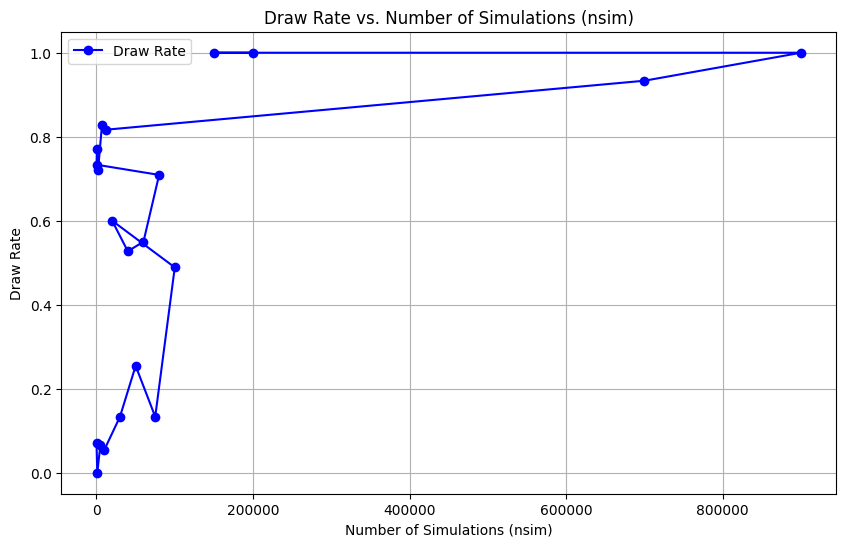

In [38]:
# Main Execution
if __name__ == '__main__':
    # Set parameters
    nsim_levels = [150000, 200000]
    # nsim_levels can be extended as needed

    bots_per_level = 15
    comp_games = 1

    # Check if 'summary_df.csv' exists
    if os.path.exists('summary_df.csv'):
        stored_data = pd.read_csv('summary_df.csv')
    else:
        stored_data = pd.DataFrame()

    # Get existing bot_ids to avoid duplicates
    existing_bot_ids = set(stored_data['bot_id'].unique()) if not stored_data.empty else set()

    # Create and test bots, adjusting bot ids to avoid duplicates
    df_summary = create_and_test_bots(nsim_levels, bots_per_level, comp_games, existing_bot_ids)

    # Concatenate stored data and new summary
    df_sim_data = pd.concat([stored_data, df_summary], ignore_index=True)

    # Drop duplicate bot_ids
    df_sim_data = df_sim_data.drop_duplicates(subset='bot_id', keep='first')

    # Save the updated data to 'summary_df.csv'
    df_sim_data.to_csv('summary_df.csv', index=False)

    # Display concatenated DataFrame
    print(df_sim_data)

    # Now, calculate the draw rate by nsim level
    nsim_values = df_sim_data['nsim'].unique()

    # Calculate total bots made at each nsim level
    total_bots = df_sim_data.groupby('nsim').size()

    # Calculate total draws, RF wins, and Perfect wins at each nsim level
    total_draws = df_sim_data.groupby('nsim')['draws'].sum()
    total_rf_wins = df_sim_data.groupby('nsim')['rf_wins'].sum()
    total_perfect_wins = df_sim_data.groupby('nsim')['perfect_wins'].sum()

    # Calculate total games at each nsim level
    total_games = df_sim_data.groupby('nsim')['total_games'].sum()

    # Calculate rates
    draw_rate = total_draws / total_games
    rf_win_rate = total_rf_wins / total_games
    perfect_win_rate = total_perfect_wins / total_games

    # Create a DataFrame to consolidate the results
    summary_df = pd.DataFrame({
        'nsim': nsim_values,
        'Total Bots': total_bots.values,
        'Total Draws': total_draws.values,
        'Total RF Wins': total_rf_wins.values,
        'Total Perfect Wins': total_perfect_wins.values,
        'Total Games': total_games.values,
        'Draw Rate': draw_rate.values,
        'RF Win Rate': rf_win_rate.values,
        'Perfect Win Rate': perfect_win_rate.values
    })

    # Ensure all rates are between 0 and 1
    summary_df[['Draw Rate', 'RF Win Rate', 'Perfect Win Rate']] = summary_df[['Draw Rate', 'RF Win Rate', 'Perfect Win Rate']].clip(0, 1)

    # Save the summary DataFrame with draw rates to CSV
    summary_df.to_csv('draw_rates_by_nsim.csv', index=False)

    # Display the summary DataFrame
    print(summary_df)

    # Plot the draw rate
    plt.figure(figsize=(10, 6))
    plt.plot(summary_df['nsim'], summary_df['Draw Rate'], marker='o', linestyle='-', color='blue', label='Draw Rate')

    # Customize the plot
    plt.xlabel('Number of Simulations (nsim)')
    plt.ylabel('Draw Rate')
    plt.title('Draw Rate vs. Number of Simulations (nsim)')
    plt.legend()
    plt.grid(True)

    # Show the plot
    plt.show()

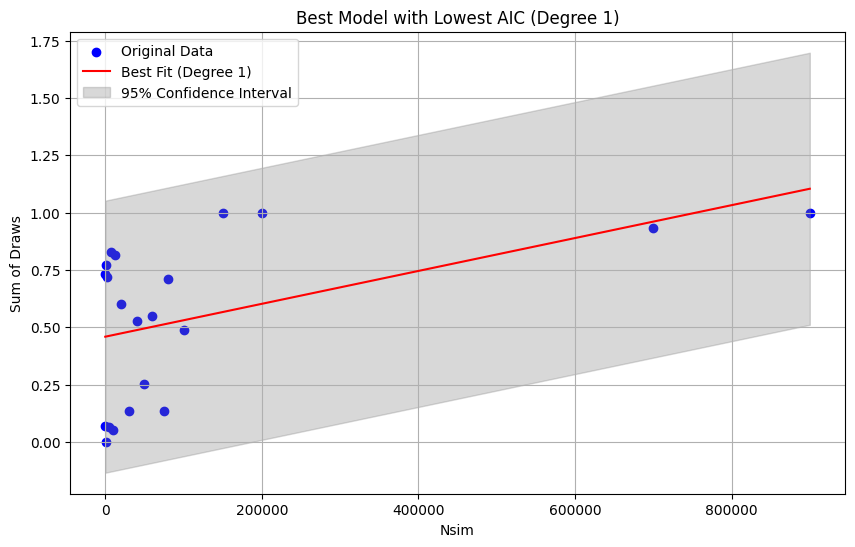

AIC Values and Coefficients for Models:

Degree 1:
AIC = -46.22
Coefficients (Betas): [7.16419907e-07 4.59166869e-01]

Degree 2:
AIC = -45.89
Coefficients (Betas): [-1.98252943e-12  2.36646688e-06  3.98829915e-01]

Degree 3:
AIC = -44.07
Coefficients (Betas): [ 2.15138177e-18 -4.53475768e-12  2.99362705e-06  3.84051057e-01]


In [39]:
# Example data: Replace with your DataFrame values
df_summary = pd.read_csv('draw_rates_by_nsim.csv')


# Function to calculate AIC
def calculate_aic(y_true, y_pred, num_params):
    residual_sum_of_squares = np.sum((y_true - y_pred) ** 2)
    n = len(y_true)
    aic = n * np.log(residual_sum_of_squares / n) + 2 * num_params
    return aic

# Fit models with linear, quadratic, and cubic terms
models = {}
aic_values = {}
coefficients_list = {}

for degree in [1, 2, 3]:  # Linear, Quadratic, Cubic
    coefficients = np.polyfit(nsim_values, draw_rate, degree)
    poly_fit = np.poly1d(coefficients)
    y_pred = poly_fit(nsim_values)
    
    # Save coefficients
    coefficients_list[degree] = coefficients
    
    # Calculate AIC
    aic = calculate_aic(draw_rate, y_pred, degree + 1)  # degree+1 parameters include the intercept
    models[degree] = poly_fit
    aic_values[degree] = aic

# Find the model with the lowest AIC
best_degree = min(aic_values, key=aic_values.get)
best_model = models[best_degree]

# Generate x values for plotting the best fit line
x_fit = np.linspace(nsim_values.min(), nsim_values.max(), 500)
y_fit = best_model(x_fit)

# Calculate residuals and standard deviation
residuals = draw_rate - best_model(nsim_values)
std_dev = np.std(residuals)

# Calculate confidence intervals
ci_upper = y_fit + 1.96 * std_dev
ci_lower = y_fit - 1.96 * std_dev

# Plot the original data and the best fit line
plt.figure(figsize=(10, 6))
plt.scatter(nsim_values, draw_rate, color='blue', label='Original Data')
plt.plot(x_fit, y_fit, color='red', label=f'Best Fit (Degree {best_degree})')
plt.fill_between(x_fit, ci_lower, ci_upper, color='gray', alpha=0.3, label='95% Confidence Interval')

# Customize the plot
plt.xlabel('Nsim')
plt.ylabel('Sum of Draws')
plt.title(f'Best Model with Lowest AIC (Degree {best_degree})')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

# Display AIC values and coefficients
print("AIC Values and Coefficients for Models:")
for degree, aic in aic_values.items():
    print(f"\nDegree {degree}:")
    print(f"AIC = {aic:.2f}")
    print("Coefficients (Betas):", coefficients_list[degree])


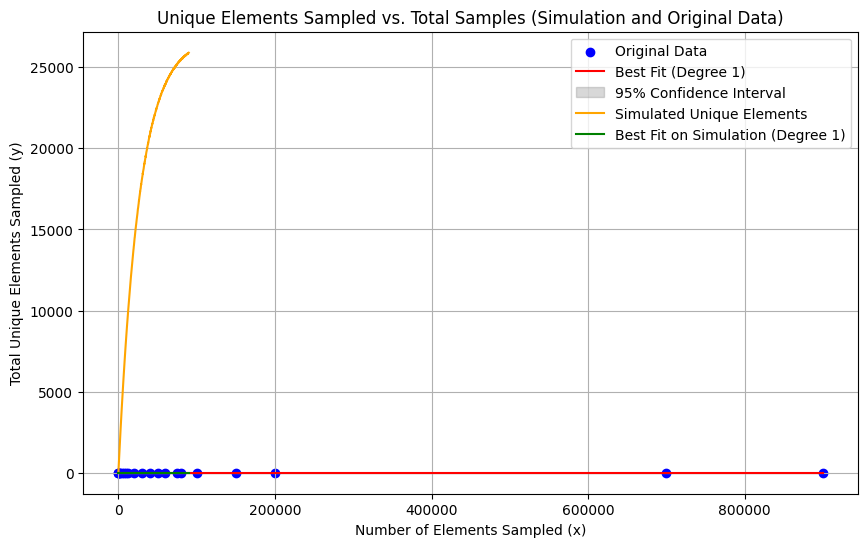

In [40]:
N = 26830  # Total unique elements
max_samples = 90000  # Maximum samples to draw
step = 100  # Step size for plotting
iterations = 10  # Number of simulations for averaging

# Simulation
unique_counts = []
for n in range(1, max_samples + 1, step):
    total_unique = []
    for _ in range(iterations):
        sampled = np.random.choice(N, n, replace=True)
        total_unique.append(len(set(sampled)))
    unique_counts.append(np.mean(total_unique))
    unique_counts_df = pd.DataFrame(unique_counts, columns=['Total Unique Elements Sampled'])
    unique_counts_df.to_csv('unique_counts.csv', index=False)


# Plot the original data and the best fit line
plt.figure(figsize=(10, 6))
plt.scatter(nsim_values, draw_rate, color='blue', label='Original Data')
plt.plot(x_fit, y_fit, color='red', label=f'Best Fit (Degree {best_degree})')
plt.fill_between(x_fit, ci_lower, ci_upper, color='gray', alpha=0.3, label='95% Confidence Interval')

# Plot the simulated unique counts
plt.plot(range(1, max_samples + 1, step), unique_counts, label='Simulated Unique Elements', color='orange')

# Plot the regression line from the best model on the simulated data
y_fit_simulation = best_model(range(1, max_samples + 1, step))
plt.plot(range(1, max_samples + 1, step), y_fit_simulation, label=f'Best Fit on Simulation (Degree {best_degree})', color='green')

# Customize the plot
plt.xlabel('Number of Elements Sampled (x)')
plt.ylabel('Total Unique Elements Sampled (y)')
plt.title('Unique Elements Sampled vs. Total Samples (Simulation and Original Data)')
plt.legend()
plt.grid()
plt.show()


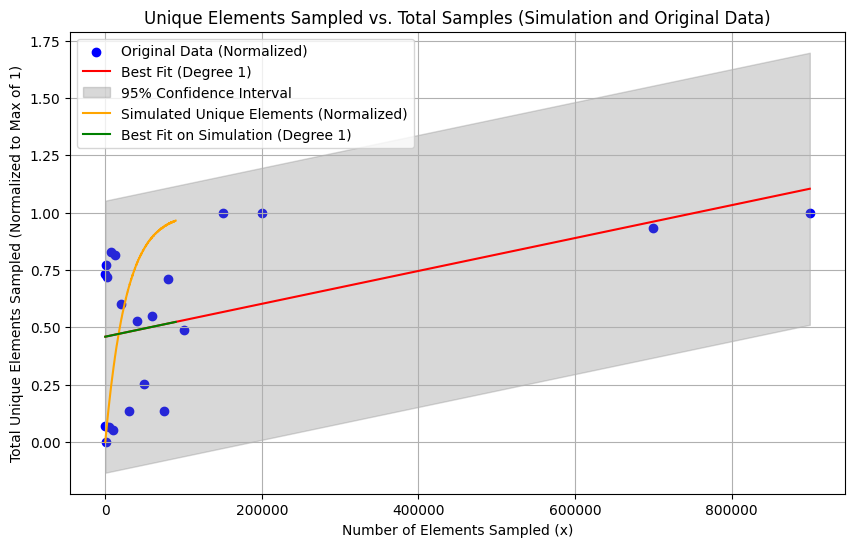

In [43]:
# Normalize the y-axis values for draws_sum and unique_counts
draws_sum_normalized = draw_rate
unique_counts_normalized = pd.read_csv('unique_counts.csv')['Total Unique Elements Sampled'] / 26830  # Normalize unique_counts to max of 1

# Fit models with linear, quadratic, and cubic terms
models = {}
aic_values = {}
coefficients_list = {}

for degree in [1, 2, 3, 4, 5]:  # Linear, Quadratic, Cubic
    coefficients = np.polyfit(nsim_values, draws_sum_normalized, degree)
    poly_fit = np.poly1d(coefficients)
    y_pred = poly_fit(nsim_values)
    
    # Save coefficients
    coefficients_list[degree] = coefficients
    
    # Calculate AIC
    aic = calculate_aic(draws_sum_normalized, y_pred, degree + 1)  # degree+1 parameters include the intercept
    models[degree] = poly_fit
    aic_values[degree] = aic

# Find the model with the lowest AIC
best_degree = min(aic_values, key=aic_values.get)
best_model = models[best_degree]

# Generate x values for plotting the best fit line
x_fit = np.linspace(nsim_values.min(), nsim_values.max(), 500)
y_fit_normalized = best_model(x_fit)

# Calculate residuals and standard deviation
residuals_normalized = draws_sum_normalized - best_model(nsim_values)
std_dev_normalized = np.std(residuals_normalized)

# Calculate confidence intervals
ci_upper_normalized = y_fit_normalized + 1.96 * std_dev_normalized
ci_lower_normalized = y_fit_normalized - 1.96 * std_dev_normalized

# Generate x values for simulated data
sim_x = np.arange(1, max_samples + 1, step)

# Plot the original data, the best fit line, and the unique counts
plt.figure(figsize=(10, 6))
plt.scatter(nsim_values, draws_sum_normalized, color='blue', label='Original Data (Normalized)')
plt.plot(x_fit, y_fit_normalized, color='red', label=f'Best Fit (Degree {best_degree})')
plt.fill_between(x_fit, ci_lower_normalized, ci_upper_normalized, color='gray', alpha=0.3, label='95% Confidence Interval')

# Plot the simulated unique counts
plt.plot(sim_x, unique_counts_normalized, label='Simulated Unique Elements (Normalized)', color='orange')

# Plot the regression line from the best model on the simulated data
y_fit_simulation_normalized = best_model(sim_x)
plt.plot(sim_x, y_fit_simulation_normalized, label=f'Best Fit on Simulation (Degree {best_degree})', color='green')

# Customize the plot
plt.xlabel('Number of Elements Sampled (x)')
plt.ylabel('Total Unique Elements Sampled (Normalized to Max of 1)')
plt.title('Unique Elements Sampled vs. Total Samples (Simulation and Original Data)')
plt.legend()
plt.grid()
plt.show()
